# Report for Ratings-Results

This report can be used to get an overview on the state of the evaluation.<br/>
It pulls the current ratings from firebase and uses different aggregations in order to create a number of visualizations and statistics.

### Pulling the data

In [ ]:
from pull_subjective_metrics import create_report_files
pull_data = True

if pull_data:
    create_report_files(
        "./keys/gs-on-a-budget-firebase-adminsdk-63ws0-509fffaf5f.json",
        "./data/ratings.xlsx",
        "./data/pairs.xlsx",
    )

### Loading and displaying the raw data

In [2]:
renamed_techniques = {
    "mini_splatting": "Mini-Splatting",
    "eagles": "EAGLES",
    "mcmc": "MCMC",
    "default": "Default",
    "mip_splatting": "Mip-Splatting",
    "gaussian_pro": "Gaussian-Pro",
    "geo_gaussian": "Geo-Gaussian",
}

In [3]:
import pandas as pd

pairs = pd.read_excel("./data/pairs.xlsx")
pairs["technique_1"] = pairs["technique_1"].apply(lambda x: renamed_techniques[x])
pairs["technique_2"] = pairs["technique_2"].apply(lambda x: renamed_techniques[x])
pairs.columns.values

array(['Unnamed: 0', 'rotation', 'model_2', 'initial_distance', 'fov_y',
       'high_detail', 'n_ratings', 'technique_1', 'model_1',
       'technique_2', 'size', 'dataset_name', 'position', 'dataset',
       'aspect', 'id'], dtype=object)

In [4]:
ratings = pd.read_excel("./data/ratings.xlsx")
ratings["timestamp"] = ratings["timestamp"].apply(pd.to_datetime)
ratings["technique_1"] = ratings["technique_1"].apply(lambda x: renamed_techniques[x])
ratings["technique_2"] = ratings["technique_2"].apply(lambda x: renamed_techniques[x])
ratings.columns.values

array(['Unnamed: 0', 'technique_2', 'size', 'rating', 'dataset',
       'user_id', 'pair_id', 'technique_1', 'timestamp', 'id', 'rating_1',
       'rating_2'], dtype=object)

### How many ratings are there per pair?

In [5]:
ratings_count_computed = ratings.groupby("pair_id")["id"].count()
df_ratings_count_computed = pd.DataFrame.from_dict({
    "pair_id": ratings_count_computed.index,
    "count": ratings_count_computed.values
}).sort_values("count", ascending=False)
df_ratings_count_computed

,pair_id,count
75,RBpxGywp1VWPYDuyRPyU,6
170,w1ddIWVExVqT9ohhNHvo,5
35,Ax0MWlYG4Hq3EEDkWFKK,5
116,d04zeljirrXjC9viZKsB,5
78,STM4xI9X7gXL7C5l0YGV,5
...,...,...
167,ufs3gdRSkQhtUMtsWnlh,1
168,vkzw6nGURAR23rFJzMQ8,1
176,xh9segHQ5UyJB9dih4b0,1
178,xqxTCtx1hcwpQzoIq86W,1


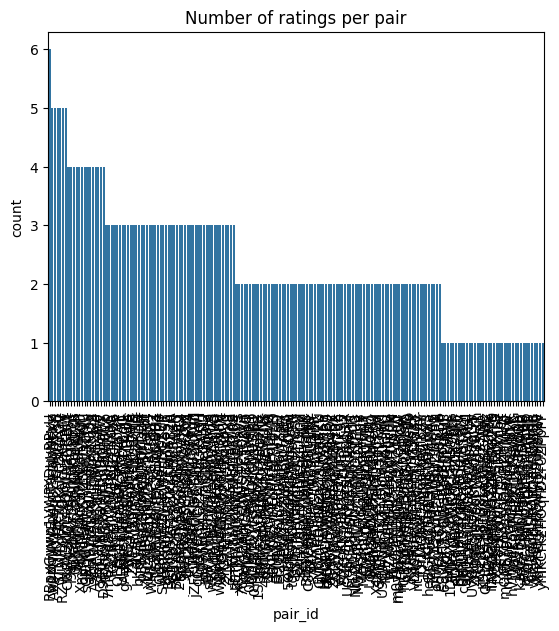

In [6]:
import seaborn as sns
from matplotlib import pyplot as plt

sns.barplot(df_ratings_count_computed, x="pair_id", y="count")
plt.xticks(rotation=90)
plt.title("Number of ratings per pair")
plt.show()

In [7]:
# Check what percentage of pairs has been covered once
print(f"{df_ratings_count_computed.shape[0]}/{pairs.shape[0]} pairs have been covered. Thats {round(df_ratings_count_computed.shape[0] / pairs.shape[0] * 100, 2)}%.")

183/189 pairs have been covered. Thats 96.83%.


In [8]:
# sanity check from ratings side if all n_ratings are actually covered by actual ratings
for idx, row in pairs.iterrows():
    if row["n_ratings"] >= 1:
        if id in ratings_count_computed:
            if not (ratings_count_computed[id] == row["n_ratings"]):
                print(f"Error! pair \"{row['id']}\" had different n_ratings than actual rating entities {row['n_ratings']} != {ratings_count_computed[id]}")
        else:
            print(f"Error! pair \"{row['id']}\" had different n_ratings than actual rating entities {row['n_ratings']} != {0}")

Error! pair "0Qbwb7Lis9pOLUVOSIrO" had different n_ratings than actual rating entities 2 != 0
Error! pair "0YwyBZxWsQpHsGv8LS61" had different n_ratings than actual rating entities 2 != 0
Error! pair "0bIsWmiOeRXEyKdMrHB1" had different n_ratings than actual rating entities 2 != 0
Error! pair "0uSshiYpzXHdIn1okZsk" had different n_ratings than actual rating entities 4 != 0
Error! pair "1DMpSYJYgWlOR38X57hm" had different n_ratings than actual rating entities 1 != 0
Error! pair "1SUpmaSAQQNMdD8FibPB" had different n_ratings than actual rating entities 2 != 0
Error! pair "1njZxACnAGt6T5qLMRlL" had different n_ratings than actual rating entities 1 != 0
Error! pair "29sPSf4gbZUmlbkLou5s" had different n_ratings than actual rating entities 2 != 0
Error! pair "2kRptcQx5PSo54pmymCi" had different n_ratings than actual rating entities 3 != 0
Error! pair "2yLwlpCr3EttnrWODivG" had different n_ratings than actual rating entities 2 != 0
Error! pair "3BPbSeLlA1pP4U3oOUfy" had different n_ratings t

In [9]:
# sanity check to see if ratings and n_ratings actually match up
for pair_id, n_ratings in ratings_count_computed.items():
    pair = pairs[pairs["id"] == pair_id]
    if pair.shape[0] != 1:
        print(f'ERROR: pair "{pair_id}" occurs "{pair.shape[0]}" times')
    db_n_ratings = pair["n_ratings"].values[0]
    if n_ratings != db_n_ratings:
        print(
            f'ERROR: pair "{pair_id}" has {n_ratings} but ratings tracker only has {db_n_ratings}'
        )

### How many ratings per user?

In [10]:
ratings_per_user = ratings.groupby("user_id")["id"].count()
df_ratings_per_user = pd.DataFrame.from_dict(
    {"user_id": ratings_per_user.index, "count": ratings_per_user.values}
).sort_values("count", ascending=False)
# df_ratings_per_user

In [11]:
df_ratings_per_user.shape

(64, 2)

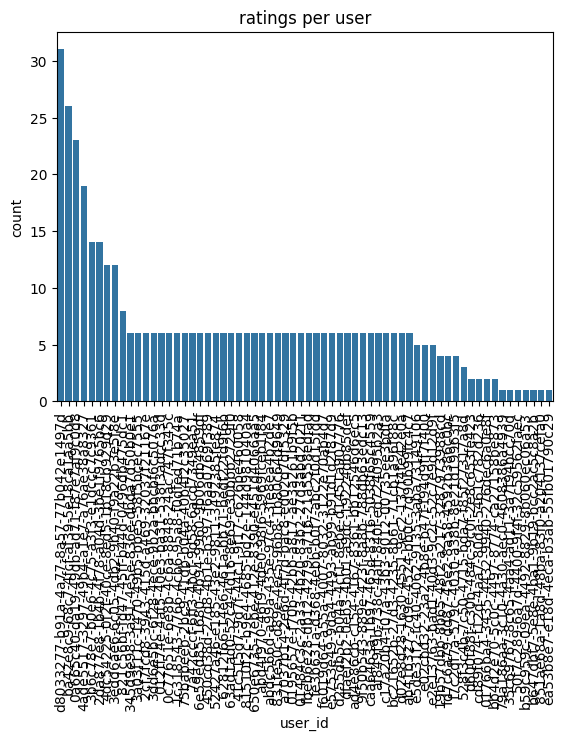

In [12]:
sns.barplot(df_ratings_per_user, x="user_id", y="count")
plt.xticks(rotation=90)
plt.title("ratings per user")
plt.show()

### How many times has every individual model been rated?

In [13]:
rating_records = []

for idx, row in ratings.iterrows():
    pair = pairs[row["pair_id"] == pairs["id"]].iloc[0]
    rating_records.append(
        {
            "model_name": str(pair["model_1"])
            .replace("splats/", "")
            .replace(".ksplat", ""),
            "preferred": row["rating"] == "first",
            "user_id": row["user_id"],
        }
    )
    rating_records.append(
        {
            "model_name": str(pair["model_2"])
            .replace("splats/", "")
            .replace(".ksplat", ""),
            "preferred": row["rating"] == "second",
            "user_id": row["user_id"],
        }
    )

df_ratings_per_model = pd.DataFrame.from_records(rating_records)
df_ratings_per_model

,model_name,preferred,user_id
0,eagles-room-medium-1,True,ad4e86cb-c154-4167-8361-bb12546d6ec5
1,gaussian_pro-room-medium-1,False,ad4e86cb-c154-4167-8361-bb12546d6ec5
2,eagles-truck-medium-1,True,d8033277-b91a-4a77-8a57-77b042e1497d
3,geo_gaussian-truck-medium-1,False,d8033277-b91a-4a77-8a57-77b042e1497d
4,default-room-medium-1,True,831fe50c-d89e-4ec5-96b8-1b80c64d9649
...,...,...,...
847,gaussian_pro-stump-high-1,False,e2e13763-bad1-40d3-9c2c-52c7e9d12d9f
848,mini_splatting-stump-medium-1,True,4ade5517-3297-49b4-a1e7-a76ae38a8327
849,eagles-stump-medium-1,False,4ade5517-3297-49b4-a1e7-a76ae38a8327
850,eagles-room-high-1,False,c17a20b4-f07a-43b3-9012-00735ee3bdfa


In [14]:
count_ratings_per_model = df_ratings_per_model.groupby("model_name")["model_name"].count()
df_count_ratings_per_model = pd.DataFrame.from_dict({
    "model_name": count_ratings_per_model.index,
    "n_ratings": count_ratings_per_model.values,
}).sort_values("n_ratings", ascending=False)
df_count_ratings_per_model

,model_name,n_ratings
14,eagles-stump-medium-1,19
0,default-room-high-1,18
52,mini_splatting-truck-low-1,18
19,gaussian_pro-room-low-1,17
17,eagles-truck-medium-1,17
...,...,...
11,eagles-room-medium-1,10
61,mip_splatting-truck-low-1,10
40,mcmc-stump-low-1,10
30,geo_gaussian-stump-high-1,9


### Whats the just objectionable difference (JOD) for each dataset/approach/size?

In [15]:
from typing import NamedTuple
import numpy as np
from scipy.optimize import minimize
from scipy.stats import norm
from matplotlib import pyplot as plt


index = {
    "Default": 0,
    "MCMC": 1,
    "Mini-Splatting": 2,
    "EAGLES": 3,
    "Mip-Splatting": 4,
    "Gaussian-Pro": 5,
    "Geo-Gaussian": 6,
}


def create_preference_matrix_from_df(df: pd.DataFrame) -> np.ndarray:
    preferences = np.zeros((7, 7), dtype=np.uint)

    for _, rating in df.iterrows():
        if rating["rating"] == "first":
            preferences[index[rating["technique_1"]]][index[rating["technique_2"]]] = (
                preferences[index[rating["technique_1"]]][index[rating["technique_2"]]]
                + 1
            )
        if rating["rating"] == "second":
            preferences[index[rating["technique_2"]]][index[rating["technique_1"]]] = (
                preferences[index[rating["technique_2"]]][index[rating["technique_1"]]]
                + 1
            )

    return preferences


# Function to calculate log-likelihood
def thurstone_log_likelihood(mu: np.ndarray, C: np.ndarray) -> float:
    n = len(mu)
    log_likelihood = 0
    for i in range(n):
        for j in range(n):
            if i != j:
                p_ij = norm.cdf((mu[i] - mu[j]) / np.sqrt(2))
                log_likelihood += C[i, j] * np.log(
                    p_ij + 1e-9
                )  # Add a small value to avoid log(0)
    return -log_likelihood


class JodResults(NamedTuple):
    default: float
    mcmc: float
    mini_splatting: float
    eagles: float
    mip_splatting: float
    gaussian_pro: float
    geo_gaussian: float

    def to_array(self) -> np.ndarray:
        return np.array(
            [
                self.default,
                self.mcmc,
                self.mini_splatting,
                self.eagles,
                self.mip_splatting,
                self.gaussian_pro,
                self.geo_gaussian,
            ]
        )


def compute_jod(preferences: np.ndarray) -> JodResults:
    # Initial guess for latent qualities
    n_stimuli = preferences.shape[0]
    mu_init = np.zeros(n_stimuli)

    # Optimize latent scores
    result = minimize(
        thurstone_log_likelihood, mu_init, args=(preferences,), method="BFGS"
    )
    [
        default,
        mcmc,
        mini_splatting,
        eagles,
        mip_splatting,
        gaussian_pro,
        geo_gaussian,
    ] = result.x

    return JodResults(
        default,
        mcmc,
        mini_splatting,
        eagles,
        mip_splatting,
        gaussian_pro,
        geo_gaussian,
    )


def plot_jod_full() -> pd.DataFrame:
    _, axs = plt.subplots(3, 3, sharex=True, sharey=True)

    records = []

    for i, size in enumerate(["low", "medium", "high"]):
        for j, dataset in enumerate(["room", "stump", "truck"]):
            current_ratings = ratings[
                (ratings["size"] == size) & (ratings["dataset"] == dataset)
            ]
            preferences = create_preference_matrix_from_df(current_ratings)
            jod_results = compute_jod(preferences)

            axs[i][j].bar(index.keys(), jod_results.to_array())
            if i == 2:
                axs[i][j].tick_params(labelrotation=90)
                plt.setp(axs[i, j], xlabel=dataset)

            if j == 0:
                plt.setp(axs[i, 0], ylabel=size)

            records.append(
                {
                    "size": size,
                    "dataset": dataset,
                    "Default": jod_results.default,
                    "MCMC": jod_results.mcmc,
                    "Mini-Splatting": jod_results.mini_splatting,
                    "EAGLES": jod_results.eagles,
                    "Mip-Splatting": jod_results.mip_splatting,
                    "Gaussian-Pro": jod_results.gaussian_pro,
                    "Geo-Gaussian": jod_results.geo_gaussian,
                }
            )

    plt.tight_layout()
    plt.show()

    return pd.DataFrame.from_records(records)

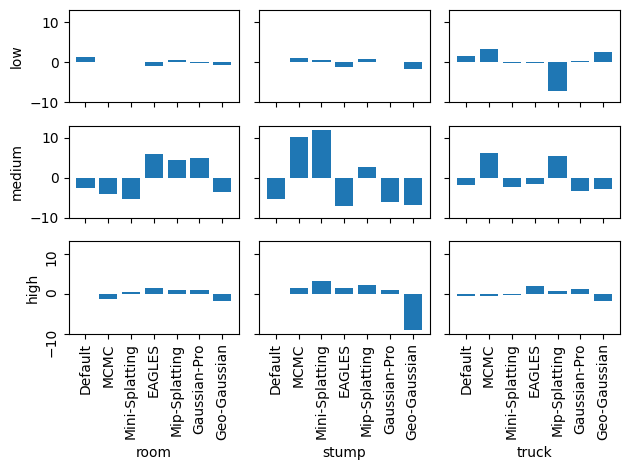

In [16]:
df_jod_full = plot_jod_full()

In [17]:
df_jod_full.to_excel("./data/jod.xlsx")

## Whats the JOD over time as more ratings come in?

In [18]:
def compute_jod_batched(batch_size: int) -> pd.DataFrame:
    records = []

    for i, size in enumerate(["low", "medium", "high"]):
        for j, dataset in enumerate(["room", "stump", "truck"]):
            current_ratings = ratings[
                (ratings["size"] == size) & (ratings["dataset"] == dataset)
            ].sort_values("timestamp", na_position="first")

            batches = [current_ratings[pd.isna(current_ratings["timestamp"])]]

            len_na = pd.isna(current_ratings["timestamp"]).sum()
            len_non_na = pd.notna(current_ratings["timestamp"]).sum()
            for i in range(0, len_non_na, batch_size):
                batches.append(
                    current_ratings.iloc[
                        0:(len_na + min(len_non_na, i + batch_size))
                    ]
                )

            for batch_idx, batch in enumerate(batches):
                preferences = create_preference_matrix_from_df(batch)
                jod_results = compute_jod(preferences)

                records.append(
                    {
                        "size": size,
                        "dataset": dataset,
                        "batch_idx": batch_idx,
                        "Default": jod_results.default,
                        "MCMC": jod_results.mcmc,
                        "Mini-Splatting": jod_results.mini_splatting,
                        "EAGLES": jod_results.eagles,
                        "Mip-Splatting": jod_results.mip_splatting,
                        "Gaussian-Pro": jod_results.gaussian_pro,
                        "Geo-Gaussian": jod_results.geo_gaussian,
                    }
                )

    return pd.DataFrame.from_records(records)

In [19]:
#df_jod_batched_10 = compute_jod_batched(10)


In [20]:
#df_jod_batched_5 = compute_jod_batched(5)

In [21]:
df_jod_batched_3 = compute_jod_batched(3)

In [22]:
#df_jod_batched_20 = compute_jod_batched(20)

In [23]:
def plot_jod_batched(df_batched: pd.DataFrame) -> None:
    _, axs = plt.subplots(3, 3, sharex=True, sharey=True)
    lines = []
    columns = ["Default", "MCMC","Mini-Splatting", "EAGLES", "Mip-Splatting", "Gaussian-Pro", "Geo-Gaussian"]
    for i, size in enumerate(["low", "medium", "high"]):
        for j, dataset in enumerate(["room", "stump", "truck"]):
            current = df_batched[
                (df_batched["size"] == size) & (df_batched["dataset"] == dataset)
            ]
            for col in columns:
                line, = axs[i][j].plot(current["batch_idx"], current[col])
                if i == 0 and j == 0:
                    lines.append(line)
            
            if i == 2:
                axs[i][j].tick_params(labelrotation=90)
                plt.setp(axs[-1, j], xlabel=dataset)
            else:
                pass
                # axs[i][j].set_xticks(["" for _ in range(len(current))])

            if j == 0:
                plt.setp(axs[i, 0], ylabel=size)

    plt.tight_layout()
    axs[1, 2].legend(lines, columns, loc="center left", bbox_to_anchor=(1, 0.5))
    plt.show()

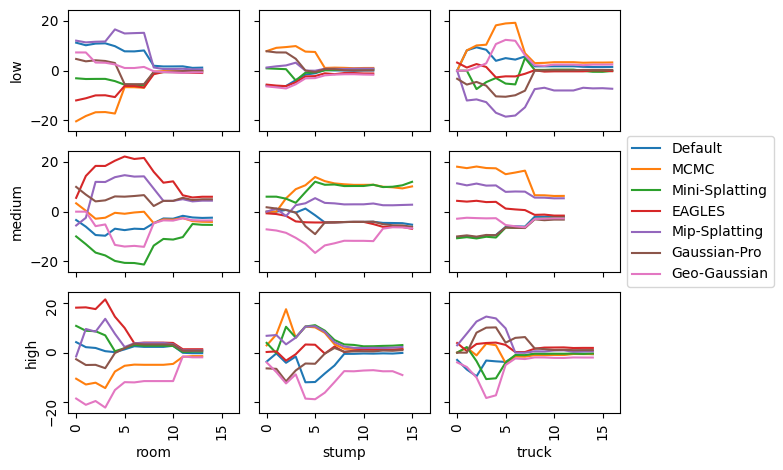

In [24]:
plot_jod_batched(df_jod_batched_3)

## Which dataset+size combination has been rated the least?

In [25]:
df_ratings_count = ratings.groupby(["dataset", "size"])["id"].count().reset_index().sort_values("id")
df_ratings_count

,dataset,size,id
6,truck,high,46
1,room,low,47
4,stump,low,47
2,room,medium,47
7,truck,low,47
8,truck,medium,47
5,stump,medium,48
3,stump,high,48
0,room,high,49


Text(0.5, 1.0, 'Ratings per facet')

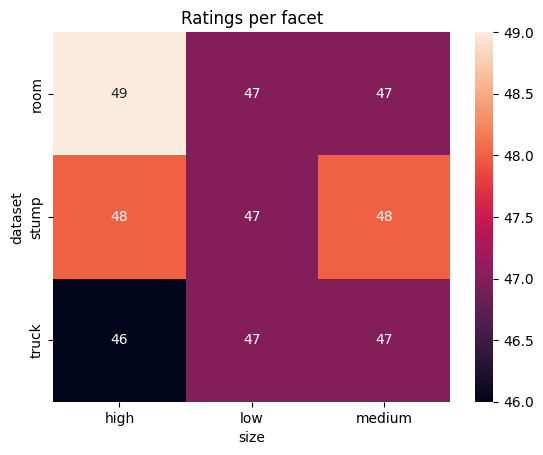

In [26]:
import seaborn as sns

sns.heatmap(
    df_ratings_count.pivot(index="dataset", columns="size", values="id"), annot=True
)
plt.title("Ratings per facet")

## About which facet are users the most undecided? 

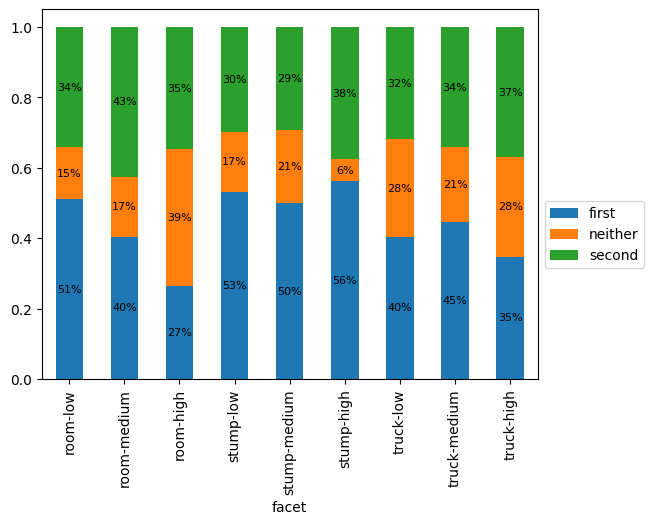

In [27]:
import numpy as np

ratings_facet = ratings.copy()
ratings_facet["facet"] = ratings_facet[["dataset", "size"]].apply(
    lambda x: f"{x.iloc[0]}-{x.iloc[1]}", axis=1
)

cross_tab = pd.crosstab(ratings_facet["facet"], ratings_facet["rating"])
row_sum = cross_tab.sum(axis=1)
cross_tab = cross_tab.apply(lambda x: x / row_sum)

idx = {"low": 0, "medium": 1, "high": 2}
def get_key(x):
    return f"{x.split('-')[0]} {idx[x.split('-')[1]]}"
cross_tab = cross_tab.sort_index(key=np.vectorize(get_key), axis=0)

ax = cross_tab.plot.bar(stacked=True)

for i, p in enumerate(ax.patches):
    width, height = p.get_width(), p.get_height()
    x, y = p.get_xy()  # Get the bottom-left coordinates of the rectangle

    # 2. Calculate label position (center of the segment)
    label_x = x + width / 2
    label_y = y + height / 2

    # 3. Add the text label
    if height > 0:  # prevent labels from showing if the height is 0
        ax.annotate(
            f"{round(cross_tab.iloc[int(i % 9)].iloc[int(i / 9)] * 100)}%",
            (label_x, label_y),
            ha="center",
            va="center",
            fontsize=8,
            color="black",
        )  # Adjust fontsize and color as needed

plt.legend(bbox_to_anchor=(1.0, 0.5))

## How stable is the JOD when cross-validating?

In [28]:
from typing import Tuple
import numpy as np
import multiprocessing as mp
from sklearn.model_selection import KFold
import itertools


def cross_validate_jod_for_circumstance(tup: Tuple[int, Tuple[str, str]]) -> np.ndarray:
    k_folds, (size, dataset) = tup
    current = ratings[(ratings["size"] == size) & (ratings["dataset"] == dataset)]
    kf = KFold(n_splits=k_folds, shuffle=True, random_state=42)
    jod_estimates = []

    for fold_idx, (train_idx, test_idx) in enumerate(kf.split(current)):
        train_data = current.iloc[train_idx]
        preferences = create_preference_matrix_from_df(train_data)
        jod_results = compute_jod(preferences)
        jod_estimates.append((fold_idx, jod_results))

    return size, dataset, jod_estimates


def compute_k_fold_cross_validation(k_folds: int) -> pd.DataFrame:
    num_workers = min(mp.cpu_count() - 1, 9)
    circumstances = list(
        itertools.product(["low", "medium", "high"], ["room", "stump", "truck"])
    )
    with mp.Pool(num_workers) as pool:
        results = pool.map(
            cross_validate_jod_for_circumstance,
            zip(
                [k_folds for _ in range(len(circumstances))],
                circumstances,
            ),
        )

    records = []

    for size, dataset, jod_estimates in results:
        for fold_idx, jod_results in jod_estimates:
            records.append(
                {
                    "size": size,
                    "dataset": dataset,
                    "fold_idx": fold_idx,
                    "Default": jod_results.default,
                    "MCMC": jod_results.mcmc,
                    "Mini-Splatting": jod_results.mini_splatting,
                    "EAGLES": jod_results.eagles,
                    "Mip-Splatting": jod_results.mip_splatting,
                    "Gaussian-Pro": jod_results.gaussian_pro,
                    "Geo-Gaussian": jod_results.geo_gaussian,
                }
            )

    return pd.DataFrame.from_records(records)


result = compute_k_fold_cross_validation(10)

In [29]:
jod_cv_20 = compute_k_fold_cross_validation(20)
jod_cv_20.to_excel("./data/jod_k_fold_20.xlsx")

In [30]:
result.to_excel("./data/jod_k_fold_10.xlsx")

In [31]:
result.groupby(["size", "dataset"]).agg(["std"])

fold_idx   Default      MCMC Mini-Splatting    EAGLES  \
                    std       std       std            std       std   
size   dataset                                                         
high   room     3.02765  0.943093  0.923811       0.870132  0.661662   
       stump    3.02765  1.323070  0.588461       0.526174  0.650281   
       truck    3.02765  0.405354  0.572219       0.338297  1.704245   
low    room     3.02765  0.278447  0.194462       0.186790  0.407881   
       stump    3.02765  0.274222  0.256145       0.218717  0.314241   
       truck    3.02765  1.822290  3.721081       1.349024  1.381024   
medium room     3.02765  1.577569  2.611739       3.764407  3.069138   
       stump    3.02765  0.855999  1.272264       1.923360  1.867773   
       truck    3.02765  0.685382  1.951929       0.507892  0.369850   

               Mip-Splatting Gaussian-Pro Geo-Gaussian  
                         std          std          std  
size   dataset                                          
high   room         0.913598     0.681125     2.994186  
       stump        0.529206     0.545508     1.390841  
       truck        0.664457     0.398577     1.647125  
low    room         0.249634     0.162249     0.226087  
       stump        0.387855     0.160688     0.231718  
       truck        1.497868     1.237557     1.799375  
medium room         1.525572     2.857215     0.889312  
       stump        1.270656     1.652948     1.637027  
       truck        0.616869     2.050652     0.493565

<Axes: xlabel='None-None', ylabel='size-dataset'>

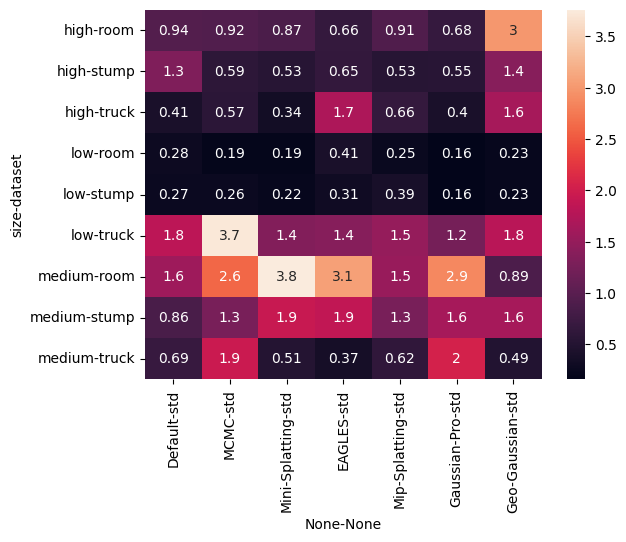

In [32]:
sns.heatmap(
    result.groupby(["size", "dataset"])
    .agg(["std"])[
        [
            "Default",
            "MCMC",
            "Mini-Splatting",
            "EAGLES",
            "Mip-Splatting",
            "Gaussian-Pro",
            "Geo-Gaussian",
        ]
    ]
    .apply(lambda x: round(x, 2)),
    annot=True,
)

## How stable is the ranking according to the JOD across all the different circustances and models?

In [33]:
# overall rank stability
ranks = result[
    [
        "Default",
        "MCMC",
        "Mini-Splatting",
        "EAGLES",
        "Mip-Splatting",
        "Gaussian-Pro",
        "Geo-Gaussian",
    ]
].rank(axis=1, ascending=False)

rank_counts = ranks.apply(pd.Series.value_counts, axis=0).fillna(0)
df_rank_overall = (rank_counts / ranks.shape[0] * 100).apply(round)

<Axes: >

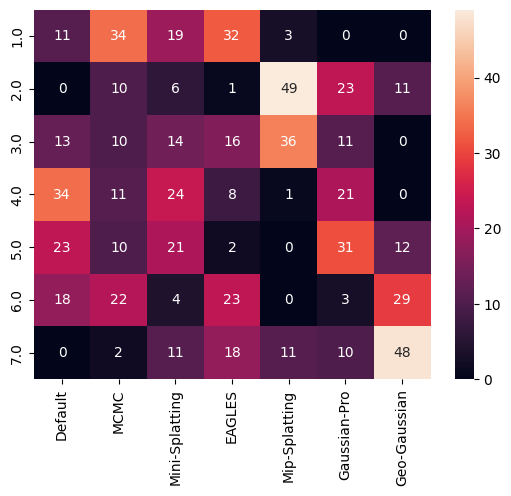

In [34]:
import seaborn as sns

sns.heatmap(df_rank_overall, annot=True)

In [35]:
def compute_rank_consistency(df_jod_cv: pd.DataFrame) -> pd.DataFrame:
    records = []

    for dataset in ["room", "stump", "truck"]:
        for size in ["low", "medium", "high"]:
            current = df_jod_cv[
                (df_jod_cv["size"] == size) & (df_jod_cv["dataset"] == dataset)
            ]
            ranks = current[
                [
                    "Default",
                    "MCMC",
                    "Mini-Splatting",
                    "EAGLES",
                    "Mip-Splatting",
                    "Gaussian-Pro",
                    "Geo-Gaussian",
                ]
            ].rank(axis=1, ascending=False)
            rank_counts = ranks.apply(pd.Series.value_counts, axis=0).fillna(0)
            best_rank = (rank_counts.max(axis=0) / ranks.shape[0] * 100).apply(round)
            (
                default,
                mcmc,
                mini_splatting,
                eagles,
                mip_splatting,
                gaussian_pro,
                geo_gaussian,
            ) = best_rank.values
            records.append(
                {
                    "size": size,
                    "dataset": dataset,
                    "Default": default,
                    "MCMC": mcmc,
                    "Mini-Splatting": mini_splatting,
                    "EAGLES": eagles,
                    "Mip-Splatting": mip_splatting,
                    "Gaussian-Pro": gaussian_pro,
                    "Geo-Gaussian": geo_gaussian,
                }
            )
    return pd.DataFrame.from_records(records)

# Rank consistency per circumstance
rank_consistency = compute_rank_consistency(result).set_index(["size", "dataset"])
rank_consistency

,,Default,MCMC,Mini-Splatting,EAGLES,Mip-Splatting,Gaussian-Pro,Geo-Gaussian
size,dataset,,,,,,,
low,room,100,60,50,90,100,60,90
medium,room,100,90,100,100,100,100,90
high,room,100,80,80,90,60,70,80
low,stump,70,80,90,100,70,70,100
medium,stump,100,70,70,70,100,90,60
high,stump,100,60,100,60,100,90,100
low,truck,100,100,70,70,100,80,100
medium,truck,80,100,90,80,100,90,80
high,truck,60,50,80,100,90,90,100


## Heatmap - Rank consistency bootrstrapped

In [36]:
from typing import Tuple
import numpy as np
import multiprocessing as mp
from sklearn.model_selection import KFold
import itertools

def bootstrap_df(df: pd.DataFrame, n_samples=100):
    for i in range(n_samples):
        yield df.sample(frac=1, replace=True, random_state=i)

def bootstrap_jod_for_circumstance(tup: Tuple[int, Tuple[str, str]]) -> np.ndarray:
    bs_samples, (size, dataset) = tup
    current = ratings[(ratings["size"] == size) & (ratings["dataset"] == dataset)]
    jod_estimates = []

    for bs_index, df_bs in enumerate(bootstrap_df(current, n_samples=bs_samples)):
        train_data = df_bs
        preferences = create_preference_matrix_from_df(train_data)
        jod_results = compute_jod(preferences)
        jod_estimates.append((bs_index, jod_results))

    return size, dataset, jod_estimates


def compute_bootstrap(bs_samples: int) -> pd.DataFrame:
    num_workers = min(mp.cpu_count() - 1, 9)
    circumstances = list(
        itertools.product(["low", "medium", "high"], ["room", "stump", "truck"])
    )
    with mp.Pool(num_workers) as pool:
        results = pool.map(
            bootstrap_jod_for_circumstance,
            zip(
                [bs_samples for _ in range(len(circumstances))],
                circumstances,
            ),
        )

    records = []

    for size, dataset, jod_estimates in results:
        for bs_index, jod_results in jod_estimates:
            records.append(
                {
                    "size": size,
                    "dataset": dataset,
                    "bs_index": bs_index,
                    "Default": jod_results.default,
                    "MCMC": jod_results.mcmc,
                    "Mini-Splatting": jod_results.mini_splatting,
                    "EAGLES": jod_results.eagles,
                    "Mip-Splatting": jod_results.mip_splatting,
                    "Gaussian-Pro": jod_results.gaussian_pro,
                    "Geo-Gaussian": jod_results.geo_gaussian,
                }
            )

    return pd.DataFrame.from_records(records)


# bs_jod = compute_bootstrap(100)

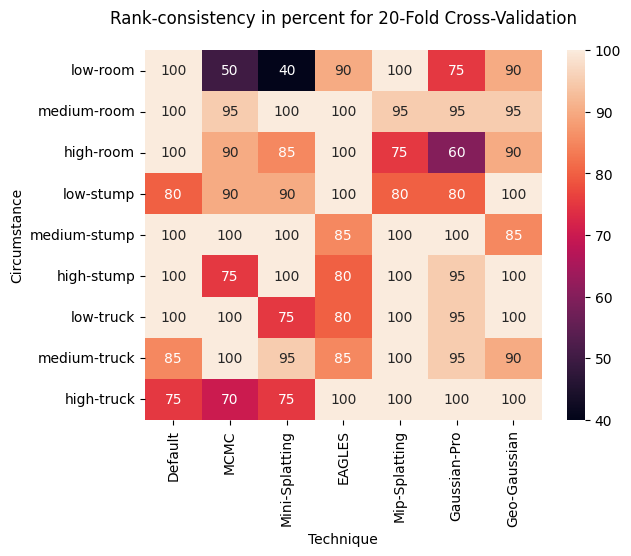

In [37]:
rank_consistency_20 = compute_rank_consistency(jod_cv_20).set_index(["size", "dataset"])
sns.heatmap(rank_consistency_20, annot=True, fmt = ".3g")
plt.xlabel("Technique")
plt.ylabel("Circumstance")
plt.title("Rank-consistency in percent for 20-Fold Cross-Validation", y=1.05)
plt.savefig("/home/paul/TUWien/MasterThesisNerf/thesis-document/graphics/results/subjective/rank-consistency-20-cv.png", bbox_inches="tight", pad_inches=0)

In [38]:
rank_consistency_20.median().median()

np.float64(95.0)

In [39]:
rank_consistency_20.melt()["value"].std()

np.float64(12.93371972754874)

In [40]:
df_ratings_per_model["model"] = df_ratings_per_model["model_name"].apply(
    lambda name: name.split("-")[0]
)
df_ratings_per_model["dataset"] = df_ratings_per_model["model_name"].apply(
    lambda name: name.split("-")[1]
)
df_ratings_per_model["size"] = df_ratings_per_model["model_name"].apply(
    lambda name: name.split("-")[2]
)
df_ratings_per_model
# df_grouped["n_splats"] = df_grouped["size"].apply(
#     lambda size: {
#         "low": 117856,
#         "medium": 412235,
#         "high": 1093135,
#         "extended": 2186270,
#     }[size]
# )
# df_grouped

,model_name,preferred,user_id,model,dataset,size
0,eagles-room-medium-1,True,ad4e86cb-c154-4167-8361-bb12546d6ec5,eagles,room,medium
1,gaussian_pro-room-medium-1,False,ad4e86cb-c154-4167-8361-bb12546d6ec5,gaussian_pro,room,medium
2,eagles-truck-medium-1,True,d8033277-b91a-4a77-8a57-77b042e1497d,eagles,truck,medium
3,geo_gaussian-truck-medium-1,False,d8033277-b91a-4a77-8a57-77b042e1497d,geo_gaussian,truck,medium
4,default-room-medium-1,True,831fe50c-d89e-4ec5-96b8-1b80c64d9649,default,room,medium
...,...,...,...,...,...,...
847,gaussian_pro-stump-high-1,False,e2e13763-bad1-40d3-9c2c-52c7e9d12d9f,gaussian_pro,stump,high
848,mini_splatting-stump-medium-1,True,4ade5517-3297-49b4-a1e7-a76ae38a8327,mini_splatting,stump,medium
849,eagles-stump-medium-1,False,4ade5517-3297-49b4-a1e7-a76ae38a8327,eagles,stump,medium
850,eagles-room-high-1,False,c17a20b4-f07a-43b3-9012-00735ee3bdfa,eagles,room,high


<Axes: ylabel='size-dataset'>

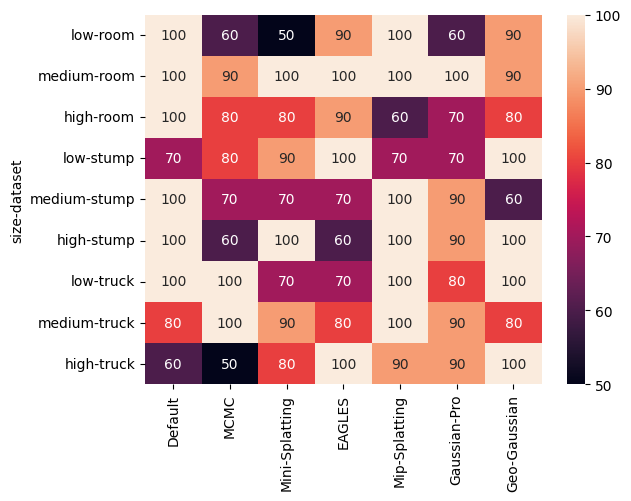

In [41]:
sns.heatmap(rank_consistency, annot=True, fmt = ".3g")

NameError: name 'df_grouped' is not defined

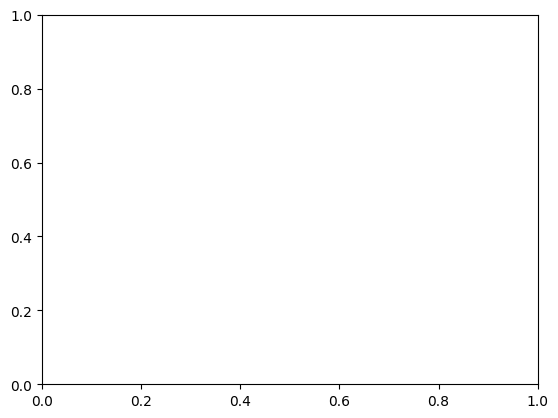

In [42]:
ax = plt.subplot()
sns.lineplot(df_grouped, x="n_splats", y="rating", hue="model", ax=ax)
plt.title("MOS per splat budget (Truck dataset)")
ax.set_xticks([117856, 412235, 1093135, 2186270], ["low", "medium", "high", "extended"])
plt.show()

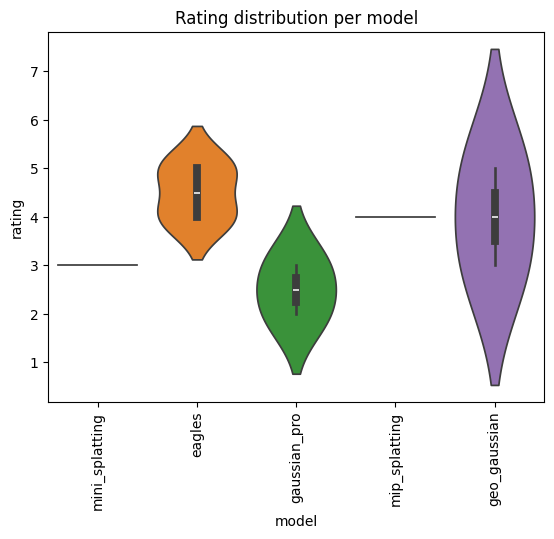

In [ ]:
sns.violinplot(df_ratings_truck, x="model", y="rating", hue="model")
plt.title("Rating distribution per model")
plt.xticks(rotation=90)
plt.show()